# Introduction
El presente proyecto consiste en la prediccion del movimiento realizado por un individuo en base a los datos obtenidos de un acelerometro de 3 ejes. Para llevar adelante esta prediccion se cuenta con un set de datos etiquetados.
La estrategia seguida para conseguir la prediccion de los movimientos se baso en las publicaciones de BAI et al (CITA). 
Este autor y otros que validaron su estrategia, trabajan con un diccionario de 'movelets'. Los movelets son secuencias de 10 datos consecutivos para los 3 ejes (ROBAR DESCRIPCION DEL MOVELET). Se toma una muestra de n cantidad de segundos para un movimiento con una etiqueta dada (en mi caso tome 9 segundos) y generan (BUSCAR DESCRIPCION DE COMO SE HACEN LO MOVELETS). Luego los datos de test no etiquetados se contrastan con los datos de los movelets y se busca para cada secuencia de 1 segundo (10 datos para cada eje del acelerometro) aquel movelet con menor sumatoria de cuadrados de diferencia para cada punto y para cada eje. Se le asigna al dato de la muestra incognita la etiqueta de ese movelet.
Luego, asumiendo que un movimiento no puede durar menos de 3 segundos se realizo un suavizado de la secuencia de etiquetas asignadas comparando con las dos etiquetas previas y las 2 etiquetas siguientes en la secuencia de tiempo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

Reading training datasets and merging both datasets based on timestamp

In [2]:
df_trts = pd.read_csv('train_time_series.csv')
df_trl = pd.read_csv('train_labels.csv')
df2 = pd.merge(df_trts,df_trl, on=['timestamp'], how = 'left')

# Exploring dataset
Graph of both unlabeled train data and labeled train data


Text(0.5, 1.0, 'Unlabeled Train data')

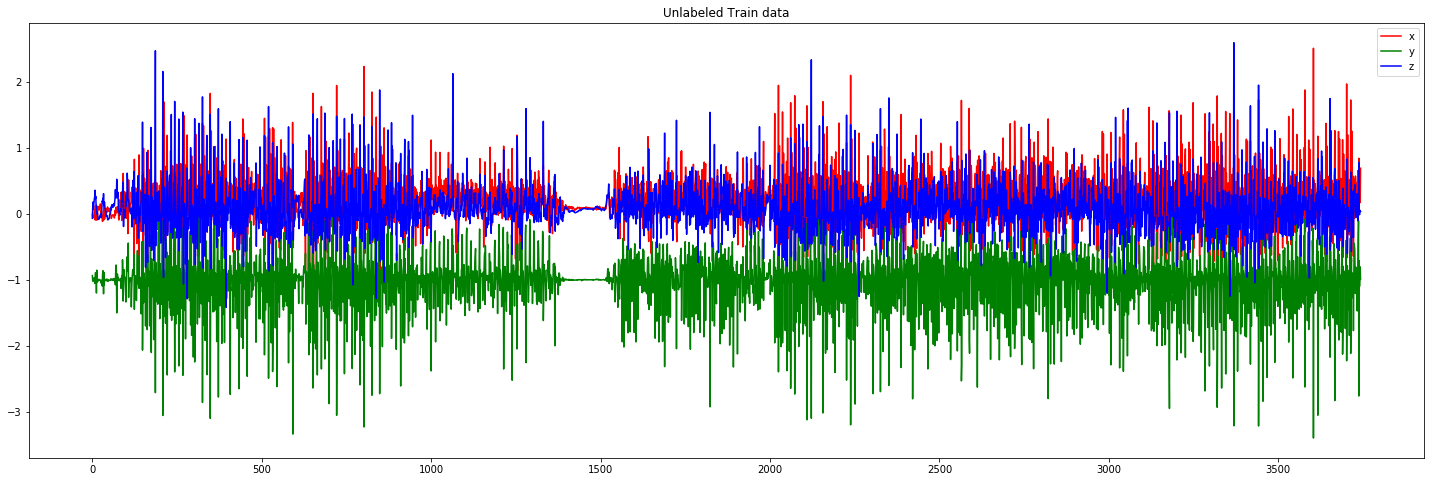

In [288]:
x = df_trts['x']
y = df_trts['y']
z = df_trts['z']
plt.figure(figsize=(25,8))
plt.plot(range(df_trts.shape[0]),x, color ='red',label = 'x')
plt.plot(range(df_trts.shape[0]),y, color ='green',label = 'y')
plt.plot(range(df_trts.shape[0]),z, color ='blue',label = 'z')
plt.legend()
plt.title('Unlabeled Train data')

Text(0.5, 1.0, 'Labeled Train data')

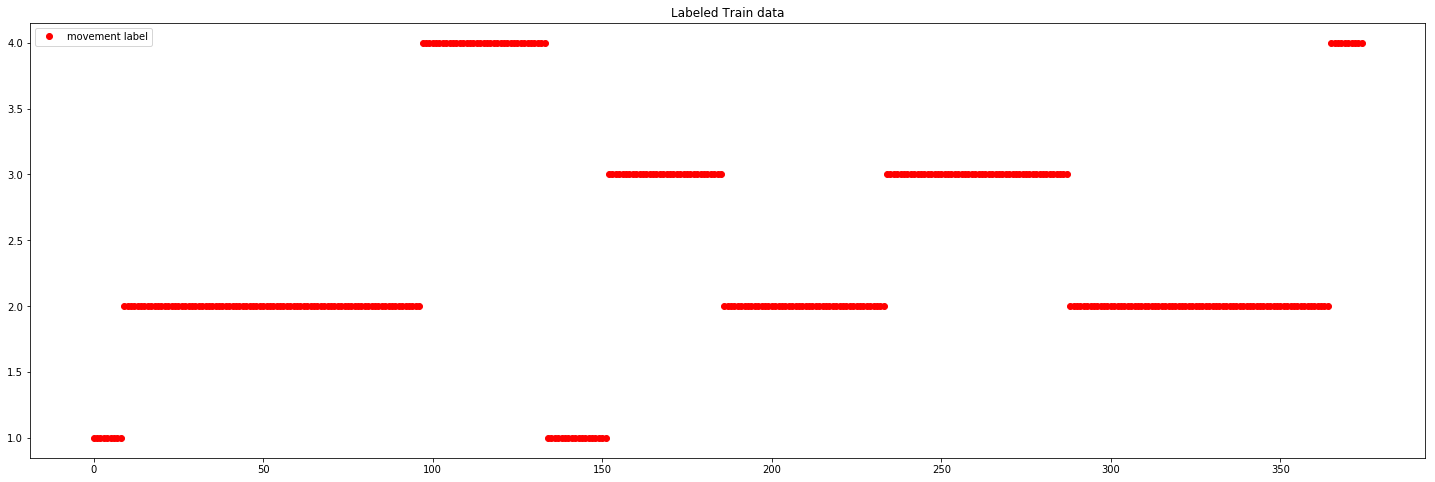

In [292]:
x = df_trl['label']
plt.figure(figsize=(25,8))
plt.plot(range(x.shape[0]),x,'o',color ='red',label = 'movement label')
plt.legend()
plt.title('Labeled Train data')

Since labels are provided on a 1Hz frequency and accelerometer data is provided in a 10hz frequency
I decided to fill de label column in the dataset with the corresponding label por that second.
Then I keep just the columns of interest

In [3]:
df2['label']= df2['label'].where(df2['label'].notnull(), 
                                other=df2['label'].fillna(method='ffill'))
df2 = df2[['timestamp','UTC time_x','x','y','z','label']]

In [4]:
df2.head()

,timestamp,UTC time_x,x,y,z,label
0,1565109930787,2019-08-06T16:45:30.787,-0.006485,-0.934860,-0.069046,NaN
1,1565109930887,2019-08-06T16:45:30.887,-0.066467,-1.015442,0.089554,NaN
2,1565109930987,2019-08-06T16:45:30.987,-0.043488,-1.021255,0.178467,NaN
3,1565109931087,2019-08-06T16:45:31.087,-0.053802,-0.987701,0.068985,1.0
4,1565109931188,2019-08-06T16:45:31.188,-0.054031,-1.003616,0.126450,1.0


Text(0.5, 1.0, 'Labeled Train Data Full Dataset')

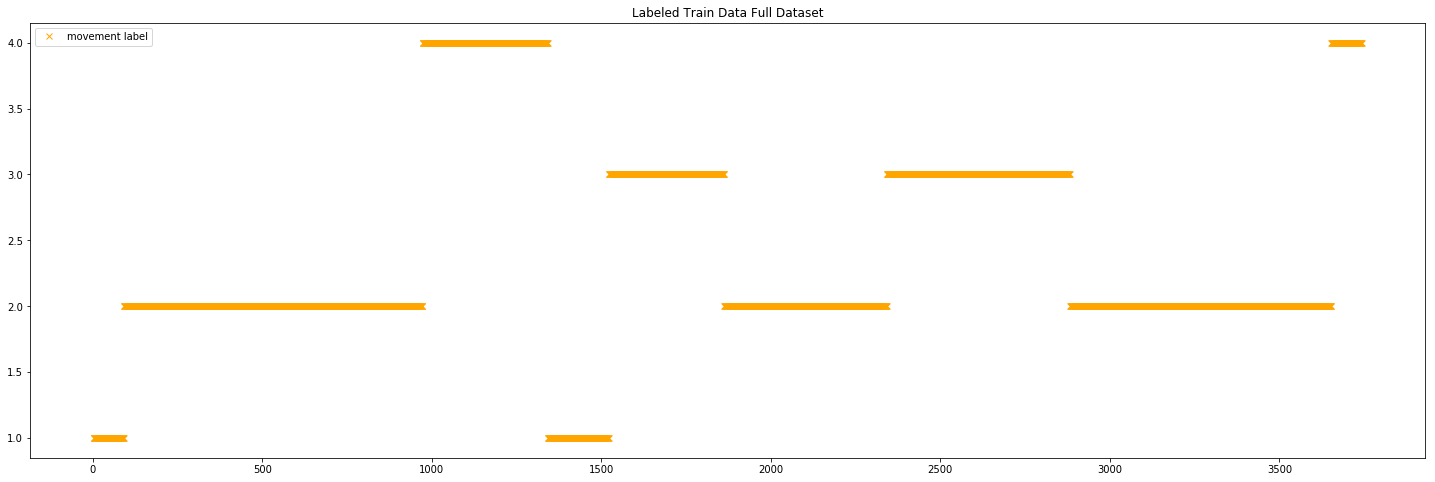

In [293]:
x = df2['label']
plt.figure(figsize=(25,8))
plt.plot(range(x.shape[0]),x,'x',color ='orange',label = 'movement label')
plt.legend()
plt.title('Labeled Train Data Full Dataset')

I define a function to generate de movelet dictionary

In [5]:
def movelet_dict_generator (dataframes,columns):
    '''this function takes a list of dataframes each one chosen for being representative of
    a given movement (label) and the columns of interest(ie. x, y, z,label) 
    to be used to generate de movelet dictionary'''
    movelet_dict = pd.DataFrame(columns = columns)
    for d in dataframes:
        movelet_dictionary =pd.DataFrame(columns = columns)
        for c in columns:
            i = 0
            j = 10
            movelet_column = []
            for n in range(d.shape[0]-10):
                movelet_column.append(d[c][i:j])
                i+=1
                j+=1
            movelet_dictionary[c] = movelet_column   
        movelet_dict = movelet_dict.append(movelet_dictionary,ignore_index=True)
    movelet_dict['label'].loc[0:80] = 1
    movelet_dict['label'].loc[80:160]= 2
    movelet_dict['label'].loc[160:240]= 3
    movelet_dict['label'].loc[240:320]= 4
    return movelet_dict


I define the dataframes representative of each movement label and run the function to generate de movelet dictionary

In [6]:
df2label1 = df2[0:90]
df2label2 = df2[260:350]
df2label3 = df2[1740:1830]
df2label4 = df2[1200:1290]
dataframes = [df2label1,df2label2,df2label3,df2label4]

movelet_dict_xyz = movelet_dict_generator(dataframes,['x','y','z','label'])

I define a function to predict the labels of test data. It calculate the square difference between the 

In [294]:
def mov_prediction(test_dataframe,movelet_dict,samples_per_label,axes):
    '''this function takes a test dataframe a movelet dict, a number of samples per label (frequency of accelerometer
    data collection) and a list of axes to be considered for the comparison with the movelet dict. It returns a list 
    of predicted labels'''
    labels = []    
    i = 0
    j = samples_per_label - 1
    for each in range(test_dataframe.shape[0]//samples_per_label):
        df_diff = pd.DataFrame(columns = axis)
        for a in axes:
            test_movelet = test_dataframe[a].loc[i:j].reset_index(drop = True)
            difference = []
            for n in range(movelet_dict.shape[0]):
                movelet_from_dict = movelet_dict[a][n].reset_index(drop=True)
                diff = sum(np.subtract(movelet_from_dict,test_movelet)**2)
                difference.append(diff)
            df_diff[a] = difference
        df_diff['total_diff'] = df_diff.sum(axis =1)
        min_loc = df_diff['total_diff'].idxmin()
        lb = movelet_dict['label'][min_loc]
        labels.append(lb)
        i+=10
        j+=10
    return labels

I define a Function to smooth the label list taking into account that movement last at least 3 seconds so abrupt movement changes are due to prediction inaccuracy and not to real movement changes

In [295]:
def smooth_labels (series,neighbors):
    '''this function takes a dataframe series corresponding to the predicted labels
    and a number of neighbor labels to smooth the predicted labels based on the fact that movements
    last at least a couple of seconds. It returns a smoothed list of labels'''
    smooth_labels = []
    neighbors = neighbors
    smooth_labels[0:0] = series.loc[0:neighbors]
    series = series.values    
    for i in range (neighbors,len(series)-neighbors):
        if any(x!=series[i] for x in smooth_labels[i-neighbors:i]) and any (y!=series[i] for y in series[i+1:i+1+neighbors]):
            smooth_labels.append(smooth_labels[i-neighbors])
            #smooth_labels.append(series[i+1])
            #smooth_labels.append(series[i+1])
        else:
            smooth_labels.append(series[i])
    for j in range (len(series)-neighbors,len(series)-1):
        smooth_labels.append(series[j])
    return smooth_labels

I generate the test dataframe importing the csv file

In [26]:
df_test_ts = pd.read_csv('test_time_series.csv')
df_test_l = pd.read_csv('test_labels.csv')
df_test= pd.merge(df_test_ts,df_test_l, on=['timestamp'], how = 'left')
df_test = df_test[['timestamp','UTC time_x','x','y','z']]

In [297]:
start_time = time.time()
label_predicted_list= mov_prediction(df_test,movelet_dict,10,['x','y','z'])
label_p_smoothed = smooth_labels(pd.Series(label_predicted_list),2)
print ("My program took", time.time() - start_time, "to run")

My program took 34.26380896568298 to run


Text(0.5, 1.0, 'smoothed vs new_alg')

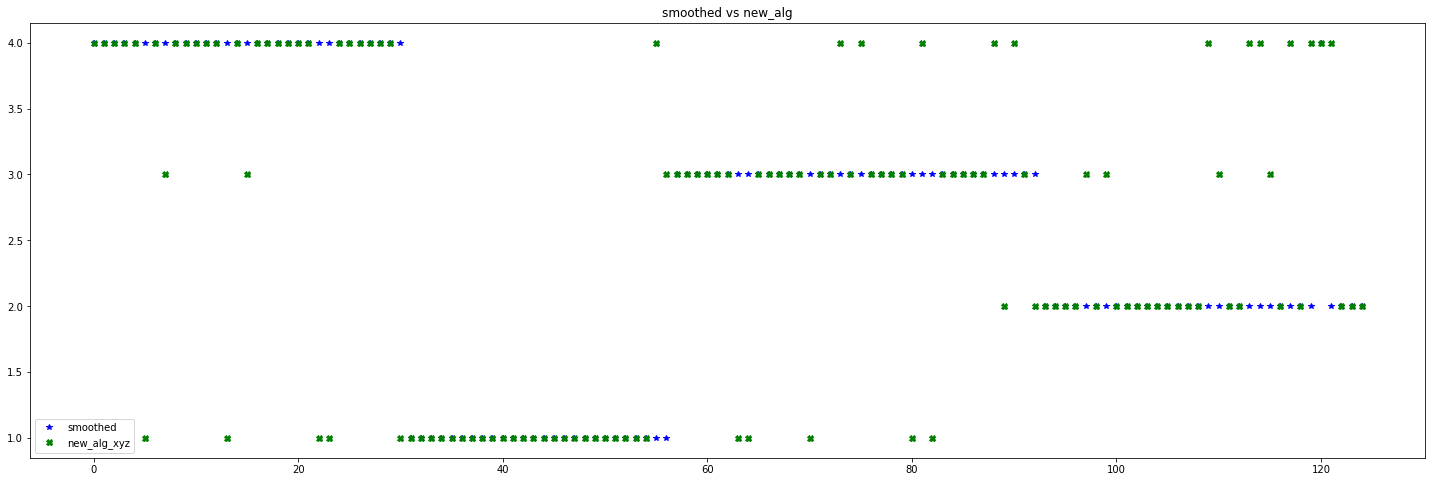

In [281]:
x = smth
plt.figure(figsize=(25,8))
#plt.plot(range(125),y,'o', color ='red',label = 'predicted')
plt.plot(range(125),x,'*',color = 'blue',label = 'smoothed')
plt.plot(range(125),label_predicted_list,'X',color = 'green',label = 'new_alg_xyz')
plt.legend()
plt.title('smoothed vs new_alg')

In [282]:
label_predicted_list= mov_prediction(df_test,movelet_dict,10,['x','y'])

Text(0.5, 1.0, 'smoothed vs new_alg')

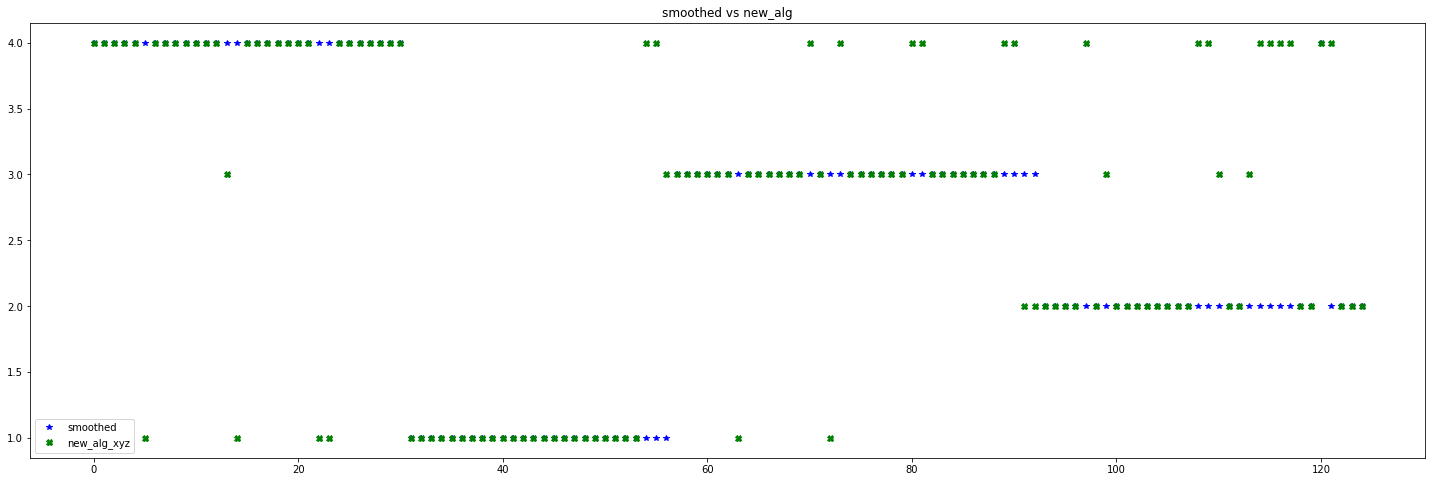

In [283]:
x = smth
plt.figure(figsize=(25,8))
#plt.plot(range(125),y,'o', color ='red',label = 'predicted')
plt.plot(range(125),x,'*',color = 'blue',label = 'smoothed')
plt.plot(range(125),label_predicted_list,'X',color = 'green',label = 'new_alg_xyz')
plt.legend()
plt.title('smoothed vs new_alg')